In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator, CubicSpline, UnivariateSpline
from scipy.optimize import minimize_scalar, differential_evolution

import math

from easygsvd import gsvd as gsvd_func
from easygsvd import random_rank_matrix

import jlinops

import os
import sys
sys.path.append("../..")


from scipy.sparse.linalg import aslinearoperator

from pytikhonov import lcorner, TikhonovFamily, discrepancy_principle, lcorner, find_lcurve_corner, plot_rdata, picard_plot, gcvmin, all_regparam_methods
from pytikhonov import rand_discrepancy_principle, rand_lcurve, rand_lcorner, rand_gcvmin
from pytikhonov import plot_gcv, plot_dp, plot_lcorner, plot_all_methods, picard_plot
from pytikhonov import golub_kahan
from pytikhonov import estimate_noise_variance, plot_monitoring_function

from pytikhonov import ProjectedTikhonovFamily

In [2]:
# Problem parameters
blur_sigma = 8.0

xtrue = jlinops.piecewise_constant_1d_test_problem()
N = len(xtrue)
A = jlinops.Gaussian1DBlurOperator(N, blur_sigma=blur_sigma, mode="constant")
A = jlinops.black_box_to_dense(A)
#A = A[::2,:]
noise_sigma = 1e-1
btrue = A @ xtrue
np.random.seed(0)
noise_vec = noise_sigma*np.random.normal(size=len(btrue))
b = btrue + noise_vec  # signal and noise
#b = noise_vec.copy() # pure noise
L, _ = jlinops.first_order_derivative_1d(N, boundary="none")
L = L.toarray()


# Should we do L1?
do_l1 = False
if do_l1:
    def mm_weights(x, epsilon, p):
        z = (x**2 + epsilon**2)**( (p-2.0)/2.0 )
        return z

    l1_epsilon = 1e-3
    l1_weighting_rule = lambda Lx, lambdah: np.sqrt(mm_weights(Lx, l1_epsilon, 1.0))
    w_true = l1_weighting_rule(L @ xtrue, 1.0)
    L = np.diag(w_true) @ L



# define tikhonov family
tf = TikhonovFamily(A, L, b, None, btrue=btrue, noise_var=noise_sigma**2)
gsvd = tf.gsvd

In [3]:
# from scipy.linalg import qr


# class ProjectedTikhonovFamily:
#     """Represents the projection of a Tikhonov problem onto an affine subspace.

#         x_lambda = argmin_{x \in x_under + col(V)} || A x - b ||_2^2 + \lambda || L x - d ||_2^2.

#     """
#     def __init__(self, A, L, V, b, d=None, x_under=None, b_under=None, d_under=None, AV=None, LV=None, btrue=None, noise_var=None):
        
#         self.A = A
#         self.L = L
#         self.M = self.A.shape[0]
#         self.N = self.A.shape[1]
#         self.K = self.L.shape[0]
#         self.noise_var = noise_var
#         self.V = V
#         self.b = b
#         if d is None: d = np.zeros(self.L.shape[0])
#         self.d = d
#         if x_under is None: x_under = np.zeros(self.A.shape[1])
#         self.x_under = x_under
#         if b_under is None: b_under = self.b - ( self.A.matvec( self.x_under ) )
#         if d_under is None: d_under = self.d - ( self.L.matvec( self.x_under ) )
#         self.b_under = b_under
#         self.d_under = d_under
#         self.btrue = btrue

#         # If AV and LV not passed, computed
#         if AV is None:
#             self.AV = A @ V
#         else:
#             self.AV = AV
        
#         if LV is None:
#             self.LV = L @ V
#         else:
#             self.LV = LV

#         # Compute GSVD and projected Tikhonov family
#         self.gsvd = gsvd_func(self.AV, self.LV, full_matrices=False)
#         self._tf = TikhonovFamily(self.AV, self.LV, self.b_under, self.d_under, gsvd=self.gsvd, btrue=self.btrue, noise_var=self.noise_var)

#         # Bind some quantities
#         self.b_hat_perp_norm_squared = self._tf.b_hat_perp_norm_squared
#         self.d_hat_perp_norm_squared = self._tf.d_hat_perp_norm_squared
#         self.squared_term = self._tf.squared_term
#         self.squared_term_rev = self._tf.squared_term_rev
#         self.gamma_check = self.gsvd.gamma_check


#     def solve(self, lambdah):
#         """Solves the projected problem for fixed lambdah.
#         """

#         z_lambdah = self._tf.solve(lambdah)
#         x_lambdah = self.x_under + ( self.V @ z_lambdah )

#         return z_lambdah, x_lambdah


#     def lcurve(self, regparams, f=None, g=None, reciprocate=False, expectation=False):
#         """Evaluates the full-scale L-curve data ( 0.5*log( || A x_{\lambda} - b ||_2^2 ), 0.5*log( || L x_{\lambda} - d ||_2 ) ) for given lambdahs.
#         """

#         assert not ( (self.btrue is None) and expectation ), "Must pass btrue to TikhonovFamily to compute expectation."

#         if f is None: f = 0.0
#         if g is None: g = 0.0

#         rho_hat = np.log(self._tf.data_fidelity(regparams, reciprocate=reciprocate, expectation=expectation) + f  )
#         eta_hat = np.log(self._tf.regularization_term(regparams, reciprocate=reciprocate, expectation=expectation) + g)

#         return rho_hat/2.0, eta_hat/2.0


#     def data_fidelity(self, regparams, reciprocate=False, expectation=False):
#         """Evaluates the full-scale data fidelity || A x_{\lambda} - b ||_2^2 for given lambdahs.
#         """

#         assert not ( (self.btrue is None) and expectation ), "Must pass btrue to TikhonovFamily to compute expectation."

#         return self._tf.data_fidelity(regparams, reciprocate=reciprocate, expectation=expectation)


#     def regularization_term(self, regparams, reciprocate=False, expectation=False):
#         """Evaluates the full-scale regularization penalty || L x_{\lambda} - d ||_2^2 for given lambdahs.
#         """
#         assert not ( (self.btrue is None) and expectation ), "Must pass btrue to TikhonovFamily to compute expectation."

#         return self._tf.regularization_term(regparams, reciprocate=reciprocate, expectation=expectation)
        
    
#     def data_fidelity_derivative(self, regparams, order=1, reciprocate=False, expectation=False):
#         """Evaluates the derivative of the full-scale data fidelity || A x_{\lambda} - b ||_2^2 for given lambdahs.
#         """

#         return self._tf.data_fidelity_derivative(regparams, order=order, reciprocate=reciprocate, expectation=expectation)


#     def regularization_term_derivative(self, regparams, order=1, reciprocate=False, expectation=False):
#         """Evaluates the derivative of the full-scale regularization penalty || L x_{\lambda} - d ||_2^2 for given lambdahs.
#         """

#         return self._tf.regularization_term_derivative(regparams, order=order, reciprocate=reciprocate, expectation=expectation)





#     # def lcurve(self, lambdah):

    

#     # def select_regparam(self, method="lcurve_min_dist_origin"):
#     #     """Performs regularization parameter selection for the projected problem.
#     #     """
#     #     valid_methods = ["dp", "lcurve", "lcurve_unprojected"]
#     #     assert method in valid_methods, f"invalid method, must be one of {valid_methods}"
#     #     if method == "dp":
#     #         assert self.delta is not None, "if using dp, must provide delta"


#     #     if method == "dp":
#     #         assert self.delta is not None, "if using dp, must provide delta"
#     #         f = np.linalg.norm( self.b_under - ( self.Q_AV @ (self.Q_AV.T @ self.b_under) ) )**2
#     #         data = discrepancy_principle(self._projected_tikhonov_family, delta=self.delta, f=f, tau=1.01, beta0=0.0)
#     #         opt_lambdah, z_lambdah = data["opt_lambdah"], data["x_lambdah"]
#     #         x_lambdah = self.x_under + ( self.V @ z_lambdah )
#     #         return opt_lambdah, z_lambdah, x_lambdah, data
        
#     #     # l-curve with maximum curvature criterion
#     #     elif method == "lcurve": # lcurve_mc
#     #         f = np.linalg.norm( self.b_under - ( self.Q_AV @ (self.Q_AV.T @ self.b_under) ) )**2
#     #         g = np.linalg.norm( self.d_under - ( self.Q_LV @ (self.Q_LV.T @ self.d_under) ) )**2
#     #         data = lcorner(self._projected_tikhonov_family, f=f, g=g, lambdah_min=1e-12, lambdah_max=1e12, num_points=1000, method="max_curvature")
#     #         opt_lambdah, z_lambdah = data["opt_lambdah"], data["x_lambdah"]
#     #         x_lambdah = self.x_under + ( self.V @ z_lambdah )
#     #         return opt_lambdah, z_lambdah, x_lambdah, data
        
#     #     # l-curve with minimum distance criterion
#     #     elif method == "lcurve_md":
#     #         f = np.linalg.norm( self.b_under - ( self.Q_AV @ (self.Q_AV.T @ self.b_under) ) )**2
#     #         g = np.linalg.norm( self.d_under - ( self.Q_LV @ (self.Q_LV.T @ self.d_under) ) )**2
#     #         data = lcorner(self._projected_tikhonov_family, f=f, g=g, lambdah_min=1e-12, lambdah_max=1e12, num_points=1000, method="min_dist_origin")
#     #         opt_lambdah, z_lambdah = data["opt_lambdah"], data["x_lambdah"]
#     #         x_lambdah = self.x_under + ( self.V @ z_lambdah )
#     #         return opt_lambdah, z_lambdah, x_lambdah, data

#     #     # l-curve with mixed cri 
#     #     elif method == "lcurve_projected":
#     #         f = 0.0
#     #         g = 0.0
#     #         data = lcorner(self._projected_tikhonov_family, f=f, g=g, lambdah_min=1e-12, lambdah_max=1e12, num_points=1000)
#     #         opt_lambdah, z_lambdah = data["opt_lambdah"], data["x_lambdah"]
#     #         x_lambdah = self.x_under + ( self.V @ z_lambdah )
#     #         return opt_lambdah, z_lambdah, x_lambdah, data

#     #     else:
#     #         raise NotImplementedError
            


In [4]:
# import numpy as np
# from scipy import optimize



# def discrepancy_principle(tikh_family, delta=None, f=None, tau=1.01, beta0=0.0):
#     """Implements the discrepancy principle root-finding method. Looks for the root of

#         phi(lambda) = || A x_lambda - b ||_2^2 + f

#     If the root does not ex

#     delta: square root of the trace of the noise covariance.
#     tau: safeguard parameter, about equal to 1.
#     f: shift in the DP functional.
#     beta0: initial condition for rootfinder. May not converge if greater than the root.
#     """

#     # is tikh_family a ProjectedTikhonovFamily?
#     if isinstance(tikh_family, ProjectedTikhonovFamily):
#         projected = True
#     else:
#         projected = False

#     # handle delta
#     if delta is None:
#         assert tikh_family.noise_var is not None, "must provide estimate of delta = sqrt(tr(\Sigma_noise))."
#         delta = np.sqrt(tikh_family.noise_var*tikh_family.M)

#     if f is None: f = 0.0
#     tau_sq_delta_sq = (tau*delta)**2
#     phi = lambda beta: tikh_family.data_fidelity(beta, reciprocate=True) + f - tau_sq_delta_sq
#     phiprime = lambda beta: tikh_family.data_fidelity_derivative(beta, order=1, reciprocate=True)

#     phi_zero = tikh_family.b_hat_perp_norm_squared + tikh_family.squared_term.sum() + f - tau_sq_delta_sq
#     phi_inf = tikh_family.b_hat_perp_norm_squared + f - tau_sq_delta_sq

#     # other stuff for plots
#     gamma_sq_min = np.amin(tikh_family.gsvd.gamma_check)**2
#     gamma_sq_max = np.amax(tikh_family.gsvd.gamma_check)**2
#     phi2 = lambda lambdah: tikh_family.data_fidelity(lambdah, reciprocate=False) + f - tau_sq_delta_sq
#     lambdahs = np.logspace( np.log10(gamma_sq_min)-2, np.log10(gamma_sq_max)+2, num=1000, base=10  )
    

#     # check if there is a root?
#     if not ( ( phi_zero > 0  ) and ( phi_inf < 0 ) ):
#         print("DP rootfinder broke, there is no root! Returning lambdah = 1e-12")
#         opt_lambdah = 1e-12
#         if not projected:
#             x_lambdah = tikh_family.solve(opt_lambdah)
#         else:
#             z_lambdah, x_lambdah = tikh_family.solve(opt_lambdah)
#         rho_hat, eta_hat = tikh_family.lcurve(opt_lambdah)
#         rho_hat *= 2
#         eta_hat *= 2
#         rho = np.exp(rho_hat)
#         eta = np.exp(eta_hat)
#         dp_vals = phi2(lambdahs)

#         data = {
#             "opt_lambdah": opt_lambdah,
#             "opt_lambdah_val": phi2(opt_lambdah),
#             "x_lambdah": x_lambdah,
#             "n_iters": None,
#             "converged": False,
#             "lambdahs": lambdahs,
#             "opt_rho": rho,
#             "opt_eta": eta,
#             "opt_rho_hat": rho_hat,
#             "opt_eta_hat": eta_hat,
#             "dp_vals": dp_vals,
#             "gamma_sq_min": gamma_sq_min,
#             "gamma_sq_max": gamma_sq_max,
#             "gamma_sq_min_val": phi2(gamma_sq_min),
#             "gamma_sq_max_val": phi2(gamma_sq_max),
#         }

#         if projected: data["z_lambdah"] = z_lambdah

#         return data
    
#     # wraph phi and phi prime to handle beta = 0 differently.
#     def _phi(beta):
#         if beta == 0.0:
#             return phi_zero
#         else:
#             return phi(beta)
        
#     def _phiprime(beta):
#         if beta == 0.0:
#             result = -2*((tikh_family.gamma_check**2)*tikh_family.squared_term).sum()
#             return result
#         else:
#             return phiprime(beta)
        
#     # Using Newton’s method with derivative
#     opt_beta, root_info = optimize.newton(_phi, x0=beta0, fprime=_phiprime, maxiter=500, full_output=True)

#     # lambdah and x_lambdah
#     opt_lambdah = 1.0/opt_beta
#     if not projected:
#         x_lambdah = tikh_family.solve(opt_lambdah)
#     else:
#         z_lambdah, x_lambdah = tikh_family.solve(opt_lambdah)
#     n_iters = root_info.iterations
#     converged = root_info.converged
#     assert converged, "rootfinder did not converge!"
    
#     # other stuff for plots
#     rho_hat_half, eta_hat_half = tikh_family.lcurve(opt_lambdah)
#     rho_hat = 2*rho_hat_half
#     eta_hat = 2*eta_hat_half
#     rho = np.exp(rho_hat)
#     eta = np.exp(eta_hat)
#     dp_vals = phi2(lambdahs)

#     data = {
#         "opt_lambdah": opt_lambdah,
#         "opt_lambdah_val": phi2(opt_lambdah),
#         "x_lambdah": x_lambdah,
#         "n_iters": n_iters,
#         "converged": converged,
#         "lambdahs": lambdahs,
#         "opt_rho": rho,
#         "opt_eta": eta,
#         "opt_rho_hat": rho_hat,
#         "opt_eta_hat": eta_hat,
#         "dp_vals": dp_vals,
#         "gamma_sq_min": gamma_sq_min,
#         "gamma_sq_max": gamma_sq_max,
#         "gamma_sq_min_val": phi2(gamma_sq_min),
#         "gamma_sq_max_val": phi2(gamma_sq_max),
#     }

#     if projected: data["z_lambdah"] = z_lambdah
    
#     return data


In [5]:
np.random.seed(0)
#V = np.random.normal(size=(N,999))
#V = np.eye(N)
_, V, _, _, _, _ = golub_kahan( aslinearoperator(A), b, 25, reorth="mgs2", tol=1e-12)
V = np.hstack([V, np.ones(N)[:,None]])
V, _ = np.linalg.qr(V)
#x_under = np.random.normal(size=N)
x_under = None

In [6]:
ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=x_under, noise_var=noise_sigma**2)

In [8]:
ldata = lcorner(ptf)

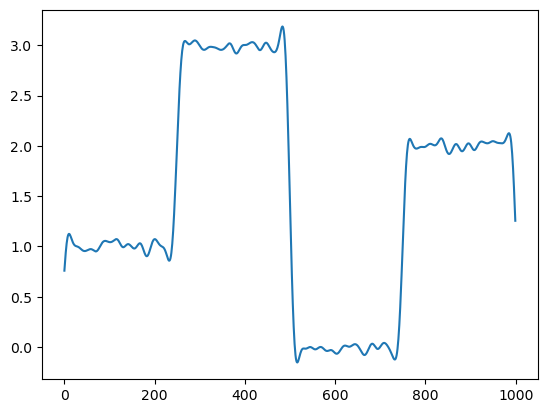

In [10]:
plt.plot(ldata["x_lambdah"])
plt.show()

In [24]:
selected_lambdahs = []
#dims = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 250, 500]
dims = [5, 10, 15, 20, 25, 30, 35]
for dim in dims:
    _, V, _, _, _, _ = golub_kahan( aslinearoperator(A), b, dim, reorth="mgs2", tol=1e-12)
    ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=x_under, noise_var=noise_sigma**2)
    ldata = lcorner(ptf)
    selected_lambdahs.append( ldata["opt_lambdah"] )


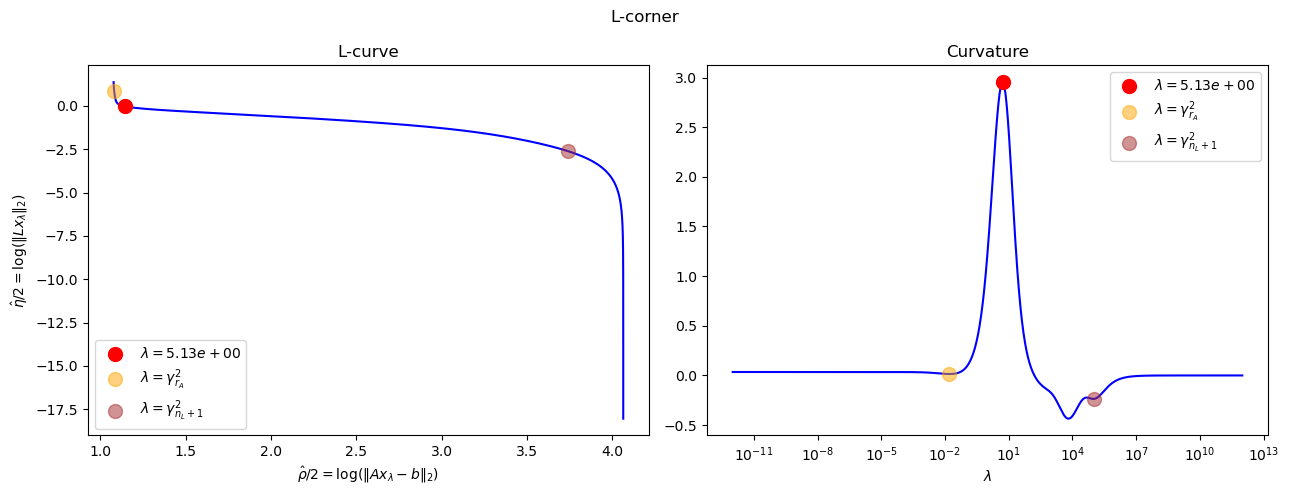

In [25]:
plot_lcorner(ldata)

In [20]:
lfull_data = lcorner(tf)

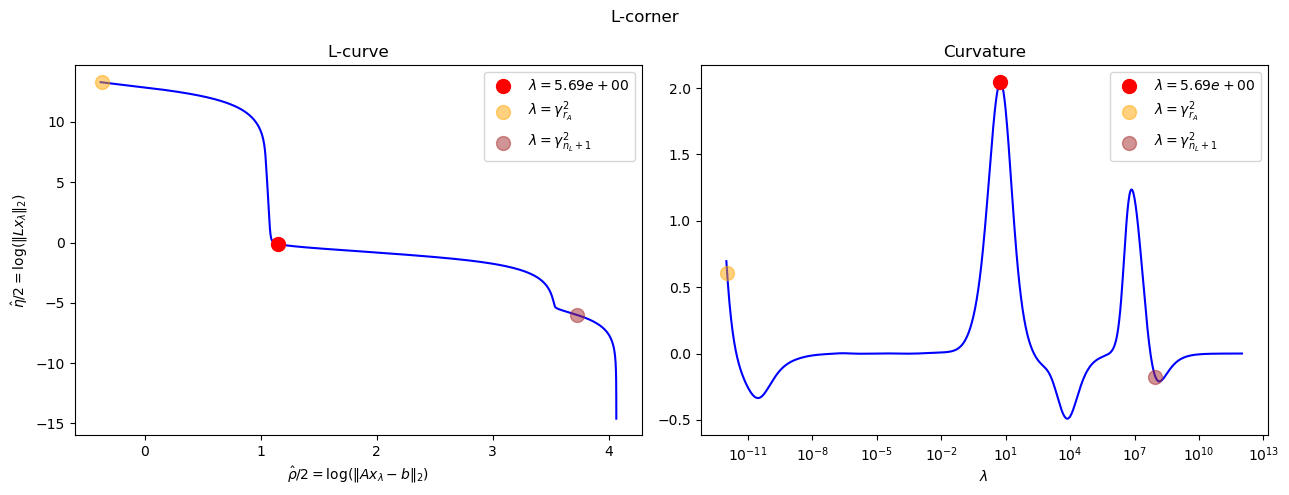

In [21]:
plot_lcorner(ldata)

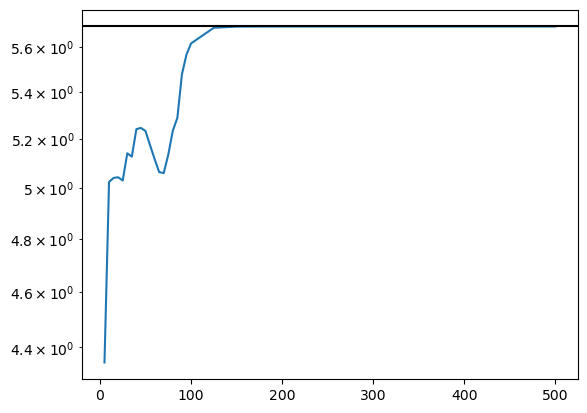

In [15]:
plt.plot(dims, selected_lambdahs)
plt.axhline(lfull_data["opt_lambdah"], color="k")
plt.yscale("log")
plt.show()

In [16]:
selected_lambdahs = []
dims = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 250, 500]
for dim in dims:
    _, V, _, _, _, _ = golub_kahan( aslinearoperator(A), b, dim, reorth="mgs2", tol=1e-12)
    ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=x_under, noise_var=noise_sigma**2)
    ldata = gcvmin(ptf)
    selected_lambdahs.append( ldata["opt_lambdah"] )


In [17]:
lfull_data = gcvmin(tf)

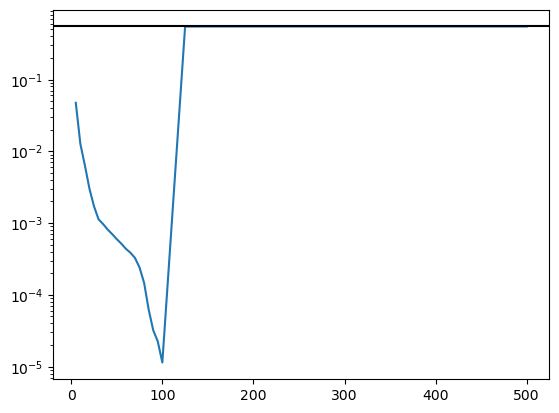

In [18]:
plt.plot(dims, selected_lambdahs)
plt.axhline(lfull_data["opt_lambdah"], color="k")
plt.yscale("log")
plt.show()

In [ ]:
plot_lcorner(ldata)

In [28]:
gcv_data = gcvmin(ptf)

In [29]:
gcv_data

{'opt_lambdah': 0.0017119932696955803,
 'opt_lambdah_val': 9.141512461376712e-06,
 'x_lambdah': array([ 1.57631784e+00,  1.50878646e+00,  1.42695518e+00,  1.33734978e+00,
         1.24762261e+00,  1.16388476e+00,  1.09033945e+00,  1.03119972e+00,
         9.87280846e-01,  9.57970482e-01,  9.40801655e-01,  9.35027219e-01,
         9.33582556e-01,  9.34102418e-01,  9.33292013e-01,  9.31556966e-01,
         9.26384413e-01,  9.21105723e-01,  9.16839691e-01,  9.17420612e-01,
         9.24118612e-01,  9.38512443e-01,  9.62176556e-01,  9.94111922e-01,
         1.03178325e+00,  1.07239116e+00,  1.11139087e+00,  1.14542156e+00,
         1.17052404e+00,  1.18421566e+00,  1.18428570e+00,  1.16970207e+00,
         1.14283661e+00,  1.10383710e+00,  1.05594426e+00,  1.00318772e+00,
         9.47150716e-01,  8.93776576e-01,  8.47707607e-01,  8.08853761e-01,
         7.83040529e-01,  7.69663814e-01,  7.72179186e-01,  7.90032811e-01,
         8.22069046e-01,  8.67767571e-01,  9.23742086e-01,  9.8525291

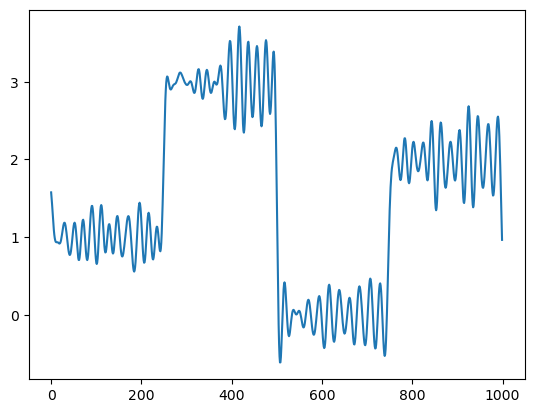

In [30]:
plt.plot(gcv_data["x_lambdah"])
plt.show()

In [31]:
discrepancy_principle(ptf)

{'opt_lambdah': 7.245329953098526,
 'opt_lambdah_val': -1.7763568394002505e-15,
 'x_lambdah': array([ 7.24673771e-01,  7.88541214e-01,  8.49037793e-01,  9.04932792e-01,
         9.55159185e-01,  9.98902312e-01,  1.03563634e+00,  1.06510678e+00,
         1.08738263e+00,  1.10280463e+00,  1.11195874e+00,  1.11557360e+00,
         1.11460041e+00,  1.10997953e+00,  1.10267942e+00,  1.09357286e+00,
         1.08350383e+00,  1.07311281e+00,  1.06294635e+00,  1.05336549e+00,
         1.04463035e+00,  1.03686072e+00,  1.03005585e+00,  1.02415650e+00,
         1.01905183e+00,  1.01458426e+00,  1.01059899e+00,  1.00692021e+00,
         1.00340095e+00,  9.99906260e-01,  9.96345151e-01,  9.92663146e-01,
         9.88808409e-01,  9.84806812e-01,  9.80716976e-01,  9.76602857e-01,
         9.72596323e-01,  9.68772423e-01,  9.65227501e-01,  9.62121713e-01,
         9.59493787e-01,  9.57452668e-01,  9.56000029e-01,  9.55158266e-01,
         9.54914729e-01,  9.55204390e-01,  9.55972382e-01,  9.57157025e

In [237]:
from scipy.sparse.linalg import aslinearoperator

In [238]:
# ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=np.eye(N), b=b, x_under=np.zeros(N), delta=(noise_sigma**2)*N)

In [245]:
np.random.seed(0)
#V = np.random.normal(size=(N,999))
#V = np.eye(N)
_, V, _, _, _, _ = golub_kahan( aslinearoperator(A), b, 50, reorth="mgs2", tol=1e-12)
V = np.hstack([V, np.ones(N)[:,None]])
V, _ = np.linalg.qr(V)
#x_under = np.random.normal(size=N)
x_under = None

In [252]:
ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=x_under, noise_var=noise_sigma**2)

In [247]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)

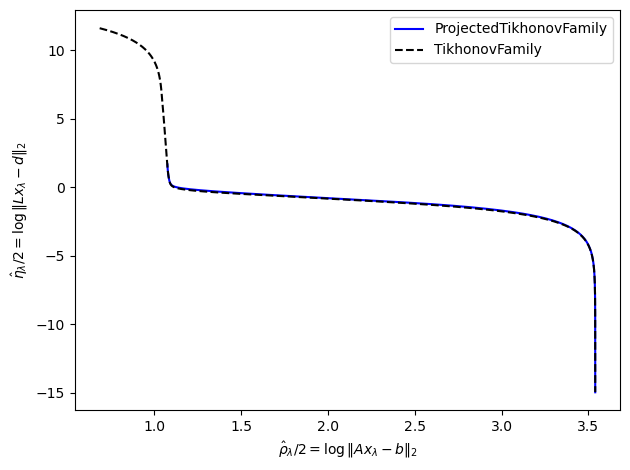

In [248]:
rho_hat_half, eta_hat_half = ptf.lcurve(lambdahs)
plt.plot(rho_hat_half, eta_hat_half, label="ProjectedTikhonovFamily", color="blue")

rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)
plt.plot(rho_hat_half, eta_hat_half, label="TikhonovFamily", ls="--", color="black")

plt.legend()
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.tight_layout()
plt.savefig("deblur_projected_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

In [88]:
Lopinv = gsvd.get_L_oblique_pinv()

In [94]:
lambdah = 1e-5
tmpmat = np.vstack([ A @ Lopinv, np.sqrt(lambdah)*np.eye(L.shape[0])  ])
tmpvec = np.hstack([ b, np.sqrt(lambdah)*np.zeros(L.shape[0])  ])
xtmp, _, _, _ = np.linalg.lstsq(tmpmat, tmpvec, rcond=None)

tmpmat = np.vstack([ A @ Lopinv, np.sqrt(lambdah)*(L @ Lopinv)  ])
tmpvec = np.hstack([ b, np.sqrt(lambdah)*np.zeros(L.shape[0])  ])
xtmp2, _, _, _ = np.linalg.lstsq(tmpmat, tmpvec, rcond=None)

print(np.linalg.norm(xtmp - xtmp2))

2.75584885644713e-07


In [167]:
lambdah = 1e-3

E, Lopinv, ALopinv, kermat = gsvd.get_L_standard_form_data()
kermat = np.ones(N)[:,None] # previous kermat was wrong!
xker = kermat @ ( np.linalg.pinv(A @ kermat) @ b )
bbar = b - (A @ xker)


_, V, _, _, _, _ = golub_kahan( aslinearoperator(ALopinv), b, 25, reorth="mgs2", tol=1e-12)
V = Lopinv @ V

ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=None, delta=np.sqrt((noise_sigma**2)*N))
_, sol1 = ptf.solve(lambdah)


_, V, _, _, _, _ = golub_kahan( aslinearoperator(ALopinv), b, 25, reorth="mgs2", tol=1e-12)
V = Lopinv @ V
vnew = np.ones(N)[:,None]
#vnew /= np.linalg.norm(vnew)
#vnew = vnew - (V @ (V.T @ vnew))
V = np.hstack([V, vnew])
ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=None, delta=np.sqrt((noise_sigma**2)*N))
_, sol2 = ptf.solve(lambdah)

In [168]:
np.linalg.norm( (sol1+xker) - (sol2) )

5.213821297687009e-10

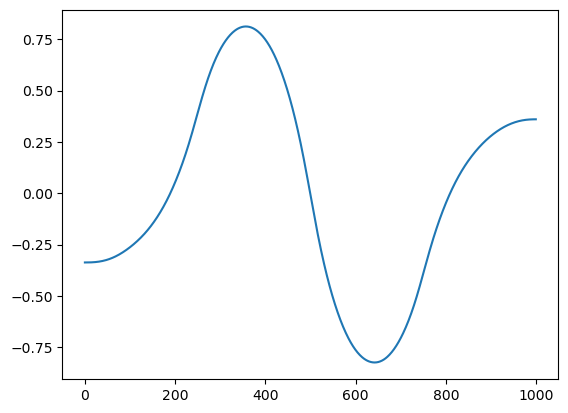

In [158]:
plt.plot(sol1)
plt.show()

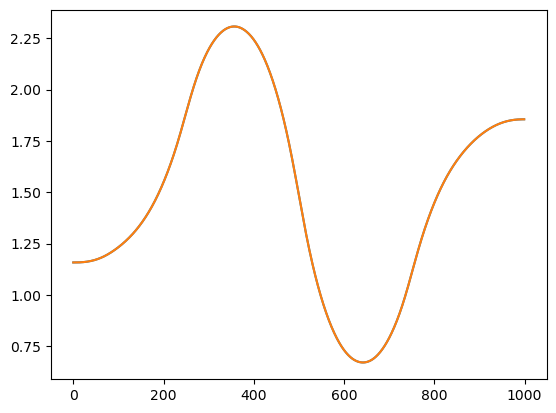

In [160]:
plt.plot(sol2)
plt.plot(sol1 + xker)
plt.show()

In [40]:
   #     if method == "dp":
    #         assert self.delta is not None, "if using dp, must provide delta"
    #         f = np.linalg.norm( self.b_under - ( self.Q_AV @ (self.Q_AV.T @ self.b_under) ) )**2
    #         data = discrepancy_principle(self._projected_tikhonov_family, delta=self.delta, f=f, tau=1.01, beta0=0.0)
    #         opt_lambdah, z_lambdah = data["opt_lambdah"], data["x_lambdah"]
    #         x_lambdah = self.x_under + ( self.V @ z_lambdah )
    #         return opt_lambdah, z_lambdah, x_lambdah, data

In [46]:
fsdp_data = discrepancy_principle(tf, delta=np.sqrt((noise_sigma**2)*N), tau=1.01, beta0=0.0)

In [50]:
selected_lambdahs = []
dims = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 250, 500]
for dim in dims:
    _, V, _, _, _, _ = golub_kahan( aslinearoperator(A), b, dim, reorth="mgs2", tol=1e-12)
    ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=x_under, delta=np.sqrt((noise_sigma**2)*N))
    dp_data = discrepancy_principle(ptf._projected_tikhonov_family, delta=np.sqrt((noise_sigma**2)*N), tau=1.01, beta0=0.0)
    selected_lambdahs.append( dp_data["opt_lambdah"] )


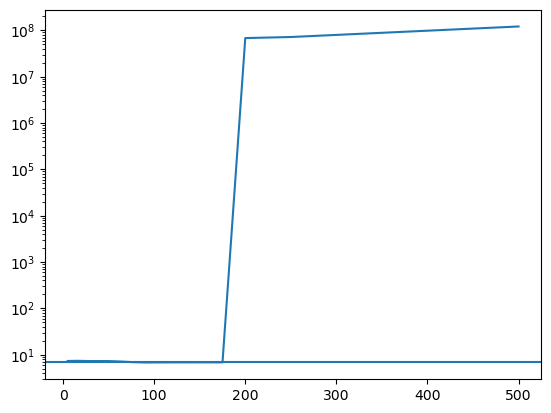

In [51]:
plt.plot(dims, selected_lambdahs)
plt.axhline(fsdp_data["opt_lambdah"])
plt.yscale("log")
plt.show()

In [24]:
discrepancy_principle(tf, delta=np.sqrt((noise_sigma**2)*N), tau=1.01, beta0=0.0)

{'opt_lambdah': 6.831907457420709,
 'opt_lambdah_val': 0.0,
 'x_lambdah': array([ 1.13347762e+00,  1.13194658e+00,  1.12893651e+00,  1.12453421e+00,
         1.11886002e+00,  1.11206462e+00,  1.10432493e+00,  1.09583902e+00,
         1.08681965e+00,  1.07748772e+00,  1.06806521e+00,  1.05876823e+00,
         1.04979938e+00,  1.04134234e+00,  1.03355574e+00,  1.02656834e+00,
         1.02047435e+00,  1.01533137e+00,  1.01115821e+00,  1.00793513e+00,
         1.00560508e+00,  1.00407729e+00,  1.00323215e+00,  1.00292721e+00,
         1.00300463e+00,  1.00329953e+00,  1.00364842e+00,  1.00389760e+00,
         1.00391056e+00,  1.00357444e+00,  1.00280469e+00,  1.00154828e+00,
         9.99784971e-01,  9.97526011e-01,  9.94812229e-01,  9.91709788e-01,
         9.88304776e-01,  9.84697877e-01,  9.80997211e-01,  9.77311498e-01,
         9.73744932e-01,  9.70390615e-01,  9.67326756e-01,  9.64612424e-01,
         9.62285588e-01,  9.60362400e-01,  9.58837291e-01,  9.57684983e-01,
         9.5686

In [13]:
lambdahs = np.logspace(-12, 12, num=20, base=10)
for lam in lambdahs:
    z_lam, x_lam = ptf.solve(lam)

    # Other way
    sol, _, _, _ = np.linalg.lstsq( np.vstack( (A, np.sqrt(lam)*L) ) @ V, np.hstack( (b - A @ x_under, -np.sqrt(lam)*L @ x_under) ), rcond=None )
    xlam2 = x_under + (V @ sol)

    print(np.linalg.norm(x_lam - xlam2 ))

8.59931499941765e-13
6.751719114141836e-13
6.777342927258643e-13
6.636570814559961e-13
6.903655007530663e-13
6.635680283259401e-13
6.351230830825865e-13
7.758448804868447e-13
2.734224956229925e-13
3.215108766877578e-14
6.677639059533185e-15
8.839862843003616e-15
7.784830546314774e-15
1.1554081923598932e-14
9.362326867301469e-15
8.025232033703014e-15
9.859032849892384e-15
9.523259652841165e-15
8.53474923929407e-15
1.21877360461762e-14


In [8]:
lambdahs = np.logspace(-12, 12, num=20, base=10)
for lam in lambdahs:
    z_lam, x_lam = ptf.solve(lam)
    print(np.linalg.norm(x_lam - tf.solve(lam)))
    #print(lam, np.linalg.norm(A @ x_lam - b), np.linalg.norm(L @ x_lam))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [18]:
aslinearoperator(A) @ np.eye(N)

array([[0.04987018, 0.04948209, 0.04833583, ..., 0.        , 0.        ,
        0.        ],
       [0.04948209, 0.04987018, 0.04948209, ..., 0.        , 0.        ,
        0.        ],
       [0.04833583, 0.04948209, 0.04987018, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.04987018, 0.04948209,
        0.04833583],
       [0.        , 0.        , 0.        , ..., 0.04948209, 0.04987018,
        0.04948209],
       [0.        , 0.        , 0.        , ..., 0.04833583, 0.04948209,
        0.04987018]])

# OLD

In [ ]:
dp_data = discrepancy_principle(tf, delta=np.sqrt(A.shape[0])*noise_sigma )

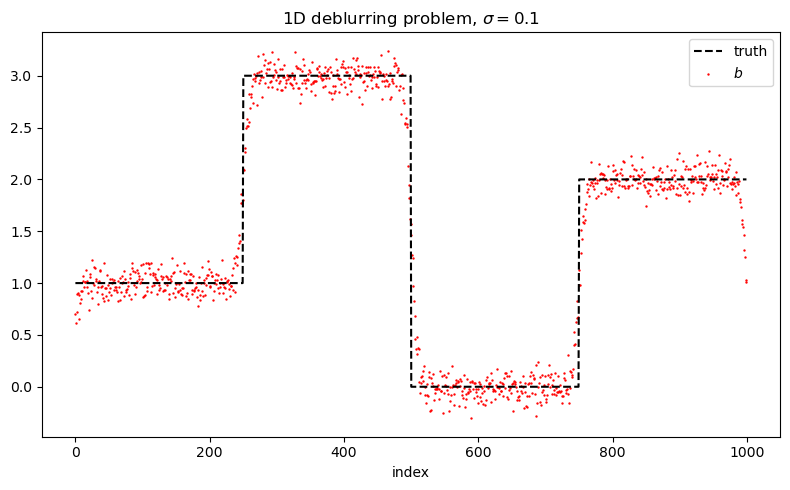

In [ ]:
idx = [i for i in range(len(b))]
plt.figure(figsize=(8,5))
plt.plot(xtrue, label="truth", ls="--", color="k")
plt.scatter(idx, b, label="$b$", color="red", s=0.5)
plt.legend()
plt.xlabel("index")
plt.title(f"1D deblurring problem, $\sigma = {noise_sigma}$")
#plt.plot(dp_data["x_lambdah"], color="blue", label="DP solution")
plt.tight_layout()
plt.savefig("deblur_data.png", dpi=250, bbox_inches=None)
plt.show()

# Call Tikhonov family

In [ ]:
tf = TikhonovFamily(A, L, b, None, btrue=btrue, noise_var=noise_sigma**2)
tf_novar = TikhonovFamily(A, L, b, None, btrue=None, noise_var=None)

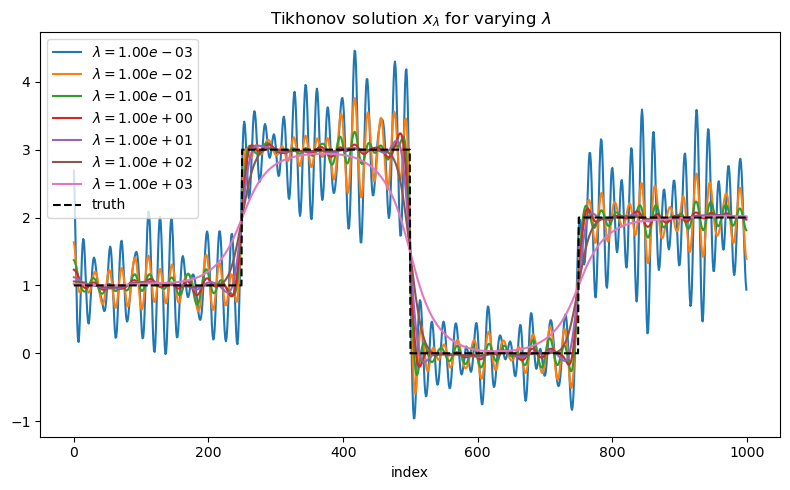

In [ ]:
idx = [i for i in range(len(b))]
plt.figure(figsize=(8,5))
lambdahs = np.logspace(-3, 3, num=7, base=10)


for lam in lambdahs:
    plt.plot(idx, tf.solve(lam), label=f"$\lambda = {lam:.2e}$")

plt.plot(xtrue, label="truth", ls="--", color="k")
#plt.scatter(idx, b, label="$b$", color="red", s=0.5)
plt.legend()
plt.xlabel("index")
plt.title(f"Tikhonov solution $x_{{\lambda}}$ for varying $\lambda$")
#plt.plot(dp_data["x_lambdah"], color="blue", label="DP solution")
plt.tight_layout()
plt.savefig("deblur_tf.png", dpi=250, bbox_inches=None)
plt.show()

In [2]:
lambdahs = np.logspace(-3, 3, num=7, base=10)

In [3]:
data_fidelities = tf.data_fidelity(lambdahs, reciprocate=False)
regularization_terms = tf.regularization_term(lambdahs, reciprocate=False)

NameError: name 'tf' is not defined

In [9]:
# Derivatives
order = 1

data_fidelities_derivs = tf.data_fidelity_derivative(lambdahs, order=1, reciprocate=False)
regularization_terms_derivs = tf.regularization_term_derivative(lambdahs, order=1, reciprocate=False)

data_fidelities_derivs = tf.data_fidelity_derivative(lambdahs, order=1, reciprocate=False)
regularization_terms_derivs = tf.regularization_term_derivative(lambdahs, order=1, reciprocate=False)

# Plot the L-curve?

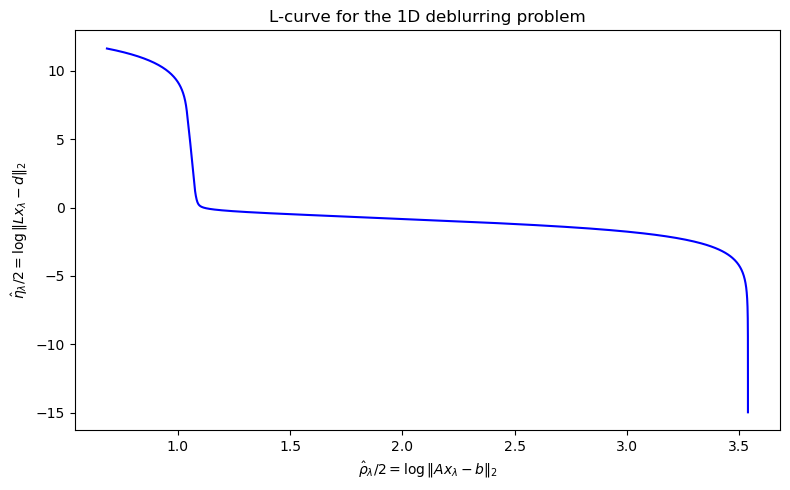

In [10]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)

plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("L-curve for the 1D deblurring problem")
plt.tight_layout()
plt.savefig("deblur_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

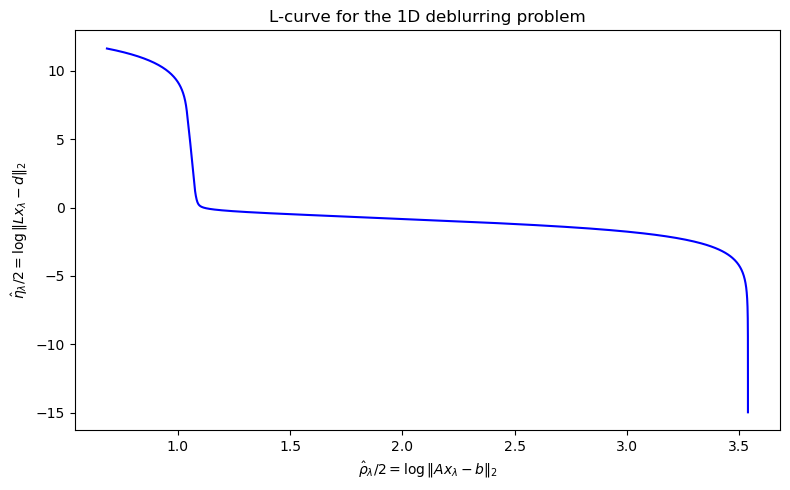

In [11]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)

plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("L-curve for the 1D deblurring problem")
plt.tight_layout()
plt.savefig("deblur_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

In [12]:
tf_pure_noise = TikhonovFamily(A, L, noise_vec, None, btrue=btrue, noise_var=noise_sigma**2)
tf_pure_signal = TikhonovFamily(A, L, btrue, None, btrue=btrue, noise_var=noise_sigma**2)

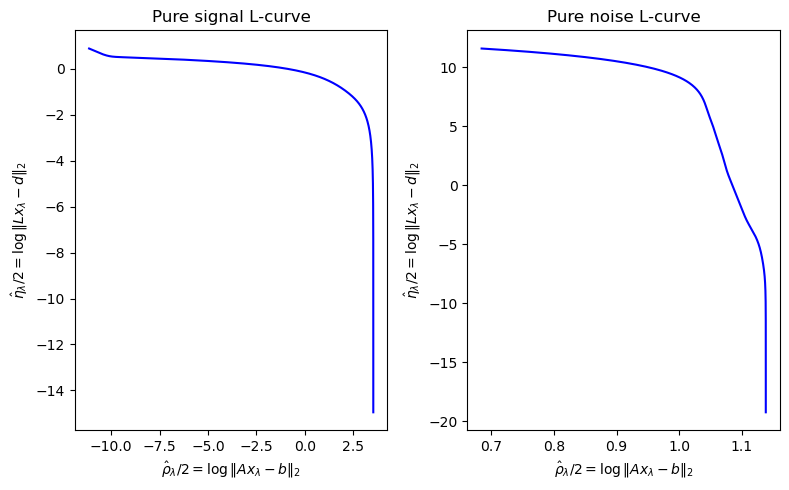

In [13]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)

fig, axs = plt.subplots(1, 2, figsize=(8,5))

rho_hat_half, eta_hat_half = tf_pure_noise.lcurve(lambdahs)
axs[1].plot(rho_hat_half, eta_hat_half, color="blue")
axs[1].set_xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
axs[1].set_ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
axs[1].set_title("Pure noise L-curve")

rho_hat_half, eta_hat_half = tf_pure_signal.lcurve(lambdahs)
axs[0].plot(rho_hat_half, eta_hat_half, color="blue")
axs[0].set_xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
axs[0].set_ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
axs[0].set_title("Pure signal L-curve")


fig.tight_layout()
fig.savefig("deblur_lcurve_pure_noise_signal.png", dpi=250, bbox_inches=None)
plt.show()

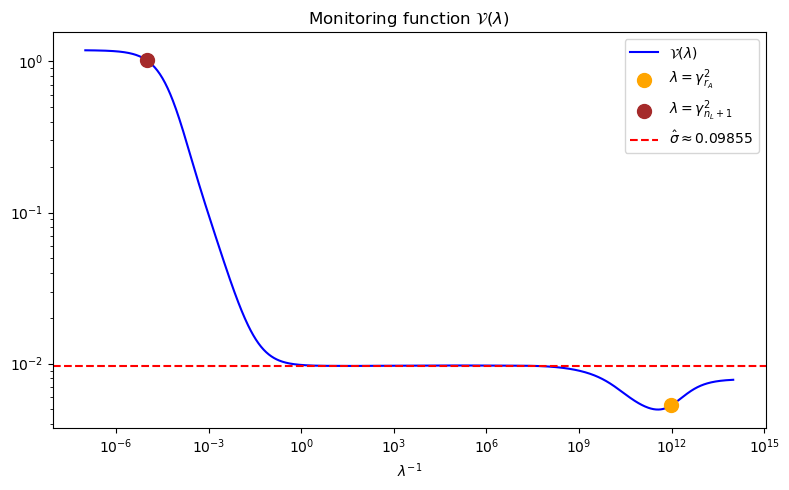

In [14]:
plot_monitoring_function(tf, plot_path="deblur_monitoring_func.png")
plot_monitoring_function(tf, plot_path=None)

In [15]:
estimate_noise_variance(tf)

0.009712696608389637

In [16]:
noise_sigma**2

0.010000000000000002

# Picard plot

In [17]:
picard_plot(tf, plot_path="deblur_picard.png")
picard_plot(tf_novar, plot_path="deblur_picard_novar.png")

# L-corner

In [18]:
ldata = lcorner(tf)

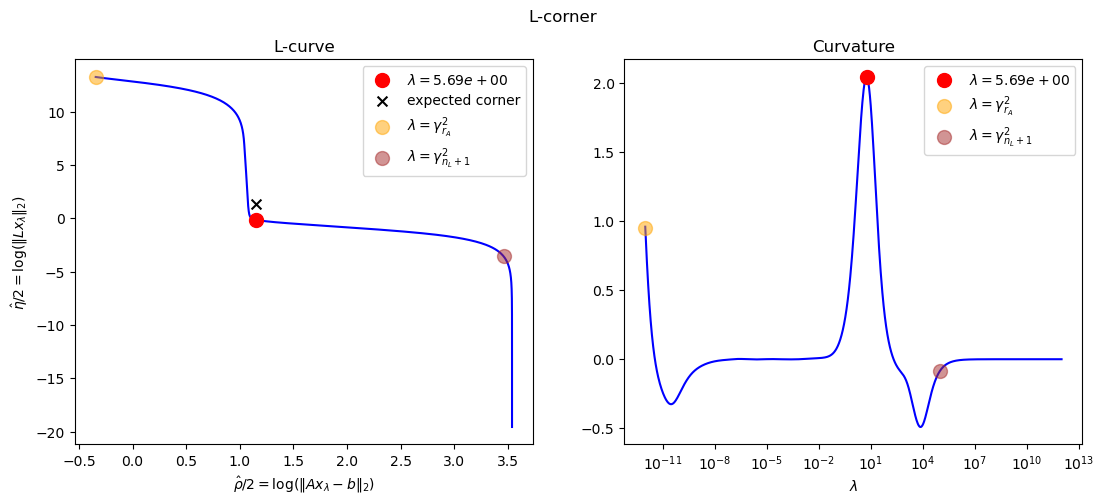

In [19]:
plot_lcorner(ldata, plot_path="deblur_lcorner.png")
plot_lcorner(ldata, plot_path=None)

# DP method

In [12]:
# noise_var_est = estimate_noise_variance(tf_novar)
# # dp_data = discrepancy_principle(tf_novar, delta=np.sqrt(A.shape[0]*noise_var_est) )

In [11]:
dp_data = discrepancy_principle(tf)

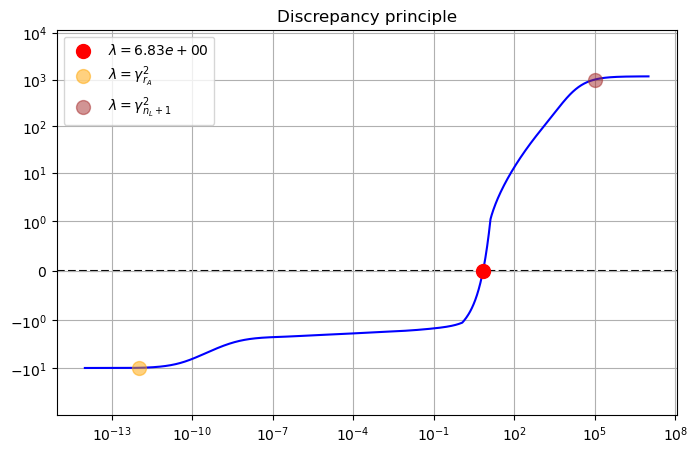

In [12]:
plot_dp(dp_data, plot_path="deblur_dp.png")
plot_dp(dp_data, plot_path=None)

In [15]:
dp_data["opt_rho_hat"]

2.322485754700382

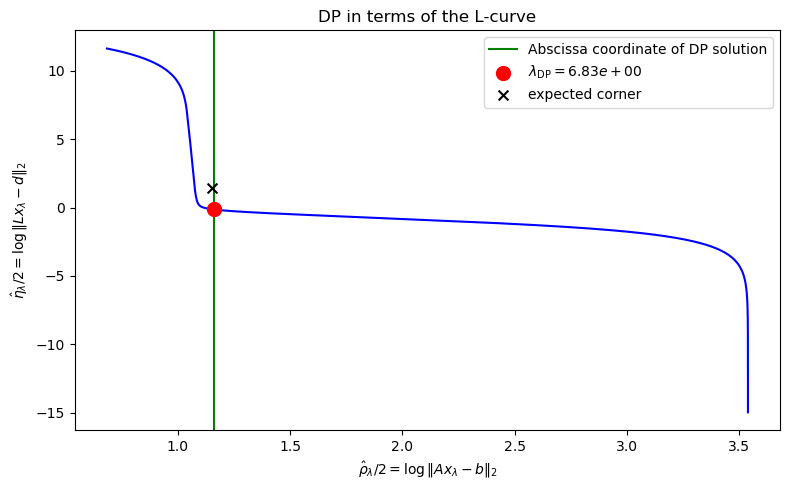

In [27]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)



plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("DP in terms of the L-curve")
plt.axvline(0.5*np.log(A.shape[0]*(noise_sigma**2)*(1.01**2)), color="green", label="Abscissa coordinate of DP solution")
opt_lambdah = dp_data["opt_lambdah"]
plt.scatter(dp_data["opt_rho_hat"]/2.0, dp_data["opt_eta_hat"]/2.0, color="red", s=100, zorder=10, label=f"$\lambda_{{\\text{{DP}}}} = {opt_lambdah:.2e}$")
plt.scatter( 0.5*np.log(  (A.shape[0] - tf.n_L)*(noise_sigma**2)  ), 0.5*np.log( tf.d_hat_perp_norm_squared + (((tf.U2.T @ btrue)**2)/(tf.gamma_check**2)).sum() ) , s=50, zorder=10, color="black", marker="x", label="expected corner" )
plt.legend()
plt.tight_layout()
plt.savefig("deblur_lcurve_with_dp.png", dpi=250, bbox_inches=None)
plt.show()

# GCV

In [7]:
gcv_data = gcvmin(tf)

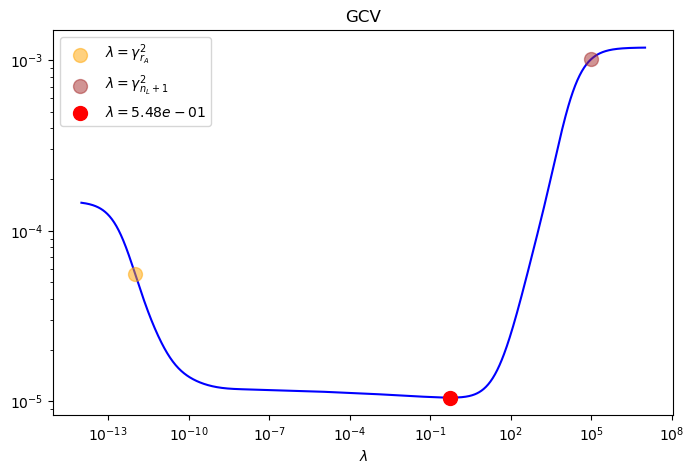

In [9]:
plot_gcv(gcv_data, plot_path="deblur_gcv.png")
plot_gcv(gcv_data, plot_path=None)

# All methods

In [11]:
all_methods = all_regparam_methods(tf)

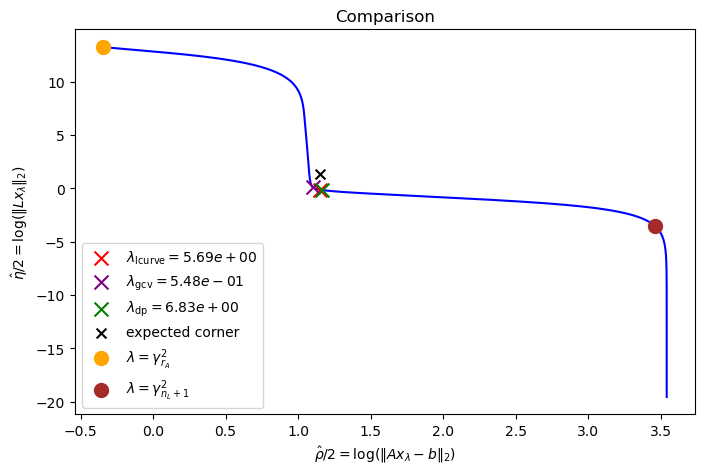

In [13]:
plot_all_methods(all_methods)
plot_all_methods(all_methods, plot_path="deblur_all_methods.png")

In [17]:
dp_lambdahs, dp_e_norms = rand_dp(tf, n_samples=10000)
lcorner_lambdahs, lcorner_e_norms = rand_lcorner(tf, n_samples=1000)
gcvmin_lambdahs, gcvmin_e_norms = rand_gcv(tf, n_samples=1000)

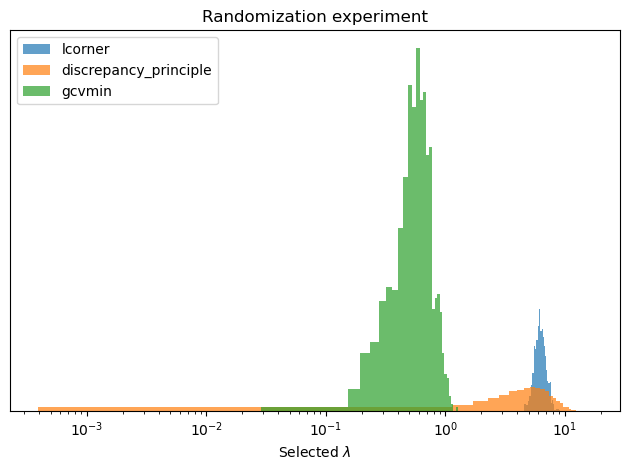

In [27]:
plt.hist(lcorner_lambdahs, bins=30, label="lcorner", density=True, alpha=0.7)
plt.hist(dp_lambdahs, bins=30, label="discrepancy_principle", density=True, alpha=0.7)
plt.hist(gcvmin_lambdahs, bins=30, label="gcvmin", density=True, alpha=0.7)
plt.yticks([])
plt.xscale("log")
plt.legend()
plt.title("Randomization experiment")
plt.xlabel("Selected $\lambda$")
plt.tight_layout()
plt.savefig("deblur_randomization_experiment.png", dpi=250, bbox_inches=None)
plt.show()

# Automatically checking DPC?

In [45]:
import numpy as np

def moving_geo_mean_rho(utb, gamma, q=3, delta=0.0, return_indices=False):
    """
    Compute rho_i = ( prod_{j=i-q}^{i+q} |u_j^T b| )^(1/(2q+1)) / gamma_i
    after removing entries with |u_i^T b| < delta. Only centers whose full
    window fits are computed, so the returned vector is shorter (no padding).

    Parameters
    ----------
    utb : (n,) array_like
        Entries u_j^T b.
    gamma : (n,) array_like
        Corresponding gamma_i (same length as utb).
    q : int
        Half-window size; window length is 2q+1.
    delta : float
        Threshold; drop indices with |u_i^T b| < delta before computing.
    return_indices : bool
        If True, also return the original indices of the centers.

    Returns
    -------
    rho : (n_valid,) ndarray
        Rho values for valid centers only (short vector).
    centers_idx : (n_valid,) ndarray of int, optional
        Returned iff return_indices=True; original indices of those centers.
    """
    utb = np.asarray(utb, dtype=float)
    gamma = np.asarray(gamma, dtype=float)
    if utb.ndim != 1 or gamma.ndim != 1 or utb.size != gamma.size:
        raise ValueError("utb and gamma must be 1-D arrays of the same length.")

    # 1) Filter by delta
    keep_mask = np.abs(utb) >= float(delta)
    kept_idx = np.flatnonzero(keep_mask)
    utb_f = utb[keep_mask]
    gamma_f = gamma[keep_mask]

    n = utb_f.size
    w = 2*q + 1
    if n < w:
        if return_indices:
            return np.array([], dtype=float), np.array([], dtype=int)
        return np.array([], dtype=float)

    # 2) Geometric mean via logs; handle zeros robustly
    a = np.abs(utb_f)
    zero_mask = (a == 0.0)
    safe_log = np.zeros_like(a)
    safe_log[~zero_mask] = np.log(a[~zero_mask])

    # Prefix sums for O(1) window aggregation
    csum_logs = np.concatenate(([0.0], np.cumsum(safe_log)))
    csum_zeros = np.concatenate(([0], np.cumsum(zero_mask.astype(int))))

    # Valid centers only: i = q ... n-q-1  (length n-2q)
    centers = np.arange(q, n - q)
    rho = np.empty(centers.size, dtype=float)

    for k, i in enumerate(centers):
        L, R = i - q, i + q
        zeros_in_win = csum_zeros[R + 1] - csum_zeros[L]
        if zeros_in_win > 0:
            gm = 0.0
        else:
            sum_logs = csum_logs[R + 1] - csum_logs[L]
            gm = np.exp(sum_logs / w)
        rho[k] = gm / gamma_f[i]

    if return_indices:
        # Map filtered centers back to original indices
        return rho, kept_idx[centers]
    return rho


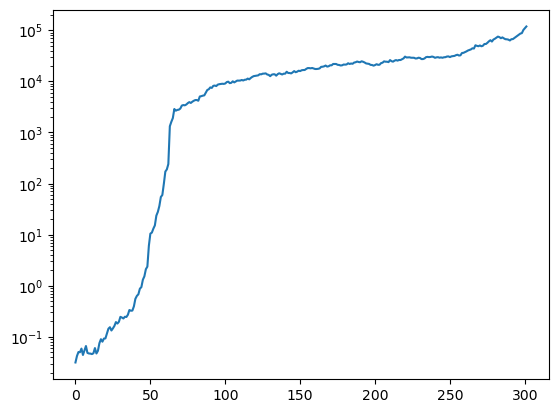

In [71]:
utb = tf.U2.T @ b
plt.semilogy(moving_geo_mean_rho(utb, tf.gamma_check, delta=1e-1, q=5))
plt.show()

In [30]:
utb = tf.U2.T @ btrue

In [27]:
np.linalg.svd( np.linalg.pinv(L) ).S

array([318.31001708, 159.15520489, 106.10368809,  79.57799515,
        63.66263174,  53.0524331 ,  45.47375719,  39.78978299,
        35.36894326,  31.83229765,  28.93870233,  26.52739471,
        24.48707764,  22.73825314,  21.2226227 ,  19.89646244,
        18.72633643,  17.68623898,  16.75563926,  15.9181126 ,
        15.16036287,  14.47151138,  13.84257142,  13.26605404,
        12.73566853,  12.24609198,  11.79279008,  11.37187624,
        10.97999998,  10.61425755,  10.27211986,   9.95137397,
         9.65007517,   9.36650755,   9.09915128,   8.84665543,
         8.60781509,   8.38155221,   8.16689928,   7.96298555,
         7.76902525,   7.58430739,   7.40818718,   7.24007839,
         7.07944695,   6.92580519,   6.77870697,   6.63774332,
         6.50253865,   6.37274742,   6.2480512 ,   6.12815605,
         6.01279021,   5.90170204,   5.79465823,   5.69144212,
         5.59185223,   5.49570103,   5.40281364,   5.3130269 ,
         5.2261883 ,   5.14215519,   5.06079399,   4.98

In [25]:
s = np.linalg.svd(L, compute_uv=False)
tol = 1e-12
s_pos = s[s > tol]
if s_pos.size == 0:
    result = 0.0
else:
    result = 1.0 / s_pos.min()

In [26]:
result

318.3100170835133

In [ ]:
1e-5

# Other

In [ ]:

def plot_gcv(gcv_data, plot_path=None):

    fig, axs = plt.subplots(figsize=(8,5))
    axs.scatter(gcv_data["gamma_sq_min"], gcv_data["gamma_sq_min_val"], label="$\lambda = \gamma_{r_A}^2$", color="orange", s=100, zorder=10, alpha=0.5)
    axs.scatter(gcv_data["gamma_sq_max"],  gcv_data["gamma_sq_max_val"], label="$\lambda = \gamma_{n_L + 1}^2$", color="brown", s=100, zorder=10, alpha=0.5)
    axs.plot( gcv_data["lambdahs"], gcv_data["gcv_vals"], color="blue")
    gcv_opt_lambdah = gcv_data["opt_lambdah"]
    axs.scatter(gcv_data["opt_lambdah"],  gcv_data["opt_lambdah_val"] , label=f"$\lambda = {gcv_opt_lambdah:.2e}$", color="red", s=100 , zorder=10)
    axs.set_xscale("log")
    axs.set_yscale("log")
    axs.set_title("GCV")
    axs.legend()

    if plot_path is not None:
        fig.savefig(plot_path, dpi=250)
        plt.close()
        return None
    else:
        plt.show()
        return None
    

In [ ]:

def plot_gcv(gcv_data, plot_path=None):

    fig, axs = plt.subplots(figsize=(8,5))
    axs.scatter(gcv_data["gamma_sq_min"], gcv_data["gamma_sq_min_val"], label="$\lambda = \gamma_{r_A}^2$", color="orange", s=100, zorder=10, alpha=0.5)
    axs.scatter(gcv_data["gamma_sq_max"],  gcv_data["gamma_sq_max_val"], label="$\lambda = \gamma_{n_L + 1}^2$", color="brown", s=100, zorder=10, alpha=0.5)
    axs.plot( gcv_data["lambdahs"], gcv_data["gcv_vals"], color="blue")
    gcv_opt_lambdah = gcv_data["opt_lambdah"]
    axs.scatter(gcv_data["opt_lambdah"],  gcv_data["opt_lambdah_val"] , label=f"$\lambda = {gcv_opt_lambdah:.2e}$", color="red", s=100 , zorder=10)
    axs.set_xscale("log")
    axs.set_yscale("log")
    axs.set_title("GCV")
    axs.legend()

    if plot_path is not None:
        fig.savefig(plot_path, dpi=250)
        plt.close()
        return None
    else:
        plt.show()
        return None
    

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("L-curve for the 1D deblurring problem")
plt.tight_layout()
plt.savefig("deblur_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

In [ ]:
ProjectedTikhonovFamily(A, L, V)